In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install torch torchvision timm


Epoch [1/10], Train Loss: 0.5576, Train Accuracy: 78.62%, Validation Accuracy: 93.80%
Epoch [2/10], Train Loss: 0.1516, Train Accuracy: 94.60%, Validation Accuracy: 92.40%
Epoch [3/10], Train Loss: 0.0632, Train Accuracy: 97.80%, Validation Accuracy: 93.90%
Epoch [4/10], Train Loss: 0.0728, Train Accuracy: 97.72%, Validation Accuracy: 96.60%
Epoch [5/10], Train Loss: 0.0580, Train Accuracy: 98.15%, Validation Accuracy: 95.30%
Epoch [6/10], Train Loss: 0.0503, Train Accuracy: 98.17%, Validation Accuracy: 97.30%
Epoch [7/10], Train Loss: 0.0440, Train Accuracy: 98.60%, Validation Accuracy: 98.30%
Epoch [8/10], Train Loss: 0.0304, Train Accuracy: 99.10%, Validation Accuracy: 93.80%
Epoch [9/10], Train Loss: 0.0857, Train Accuracy: 97.55%, Validation Accuracy: 96.00%
Epoch [10/10], Train Loss: 0.0483, Train Accuracy: 98.28%, Validation Accuracy: 96.00%


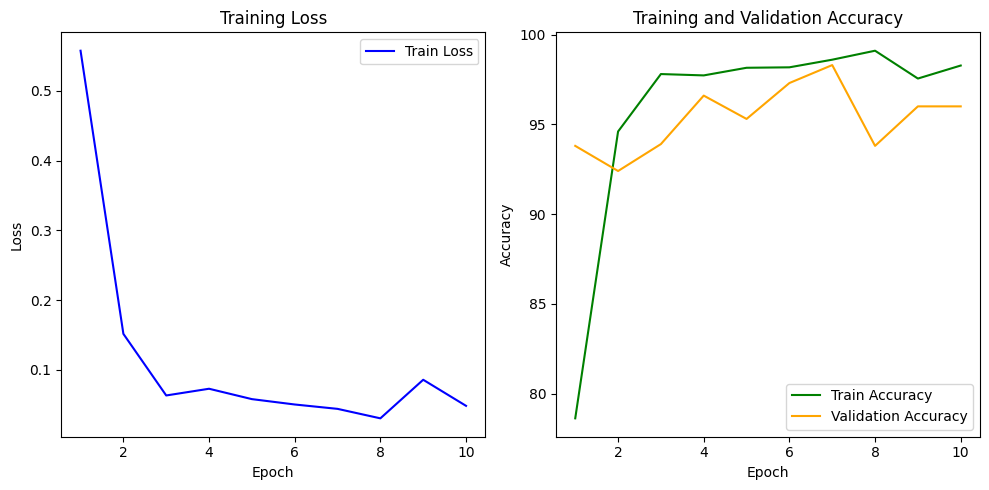

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Assuming your dataset is in folders trainset and testset
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/testset', transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'vit_model.pth')

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix:
[[0.99 0.   0.   0.   0.   0.01 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.08 0.   0.01 0.7  0.   0.19 0.   0.01 0.01 0.  ]
 [0.   0.   0.01 0.   0.95 0.   0.02 0.02 0.   0.  ]
 [0.01 0.   0.   0.   0.   0.98 0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.   0.01 0.   0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


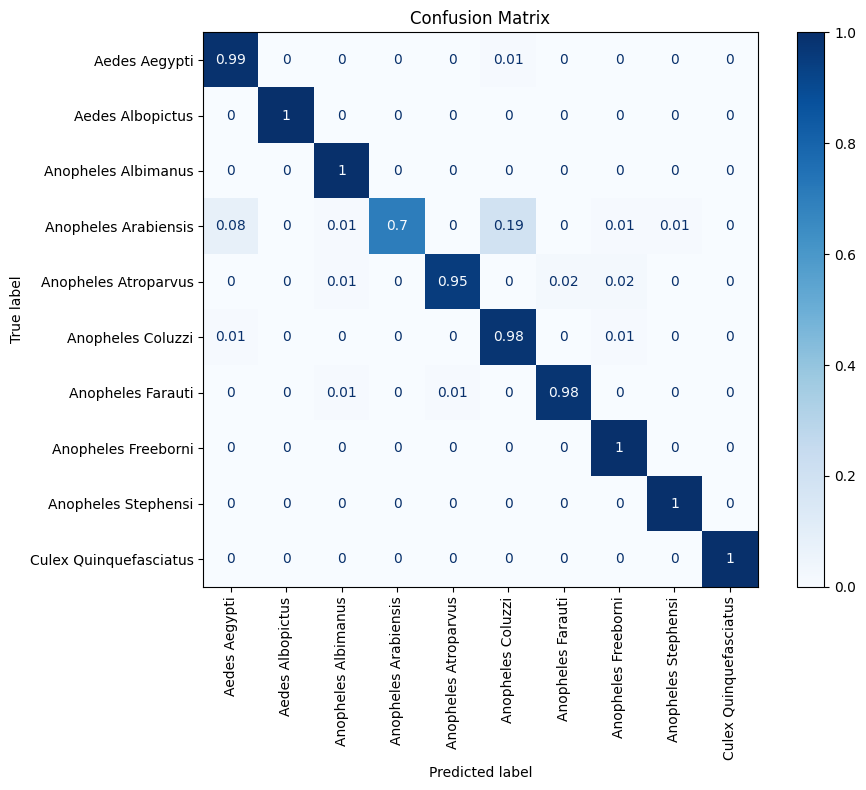

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Assuming your dataset is in folders trainset and testset
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/testset', transform=test_transform)

# Data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)
model.load_state_dict(torch.load('vit_model.pth', map_location=device))
model.eval()

# Define class names manually
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Get the true labels and predictions for the test set
val_true_labels = []
val_predictions = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    val_true_labels.extend(labels.cpu().numpy())
    val_predictions.extend(predicted.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, normalize='true')

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
import shutil

# Move the model to Google Drive
shutil.move('/content/vit_model.pth', '/content/drive/MyDrive/vit_model.pth')
print("Model moved to Google Drive as 'vit_model.pth'")


Model moved to Google Drive as 'vit_model.pth'


Saving Aedes Aegypti_29.jpg to Aedes Aegypti_29 (1).jpg


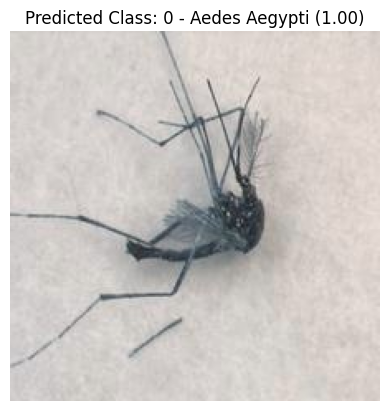

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the VIT model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        model.eval()
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


FileUpload(value={}, accept='image/*', description='Upload')

Recalibrated Scores:
Aedes Aegypti: 0.9950
Aedes Albopictus: 0.9992
Anopheles Albimanus: 0.9922
Anopheles Arabiensis: 0.9740
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9998
Anopheles Freeborni: 0.2566
Anopheles Stephensi: 0.9990
Culex Quinquefasciatus: 0.7847


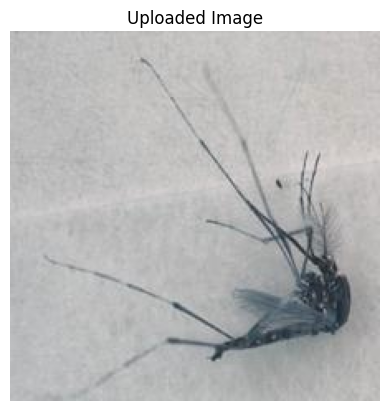

Predicted Class: Anopheles Freeborni
Recalibrated Scores:
Aedes Aegypti: 0.9917
Aedes Albopictus: 0.9998
Anopheles Albimanus: 0.9730
Anopheles Arabiensis: 0.9983
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 0.9998
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.0552
Anopheles Stephensi: 0.9996
Culex Quinquefasciatus: 0.9830


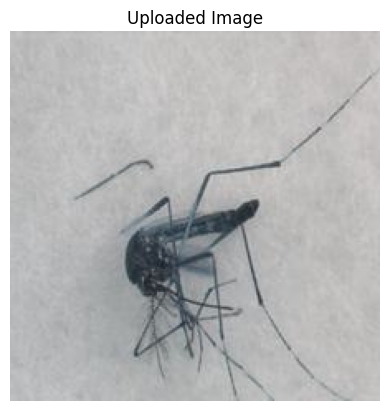

Predicted Class: Anopheles Freeborni
Recalibrated Scores:
Aedes Aegypti: 1.0000
Aedes Albopictus: 0.9959
Anopheles Albimanus: 0.9997
Anopheles Arabiensis: 0.9996
Anopheles Atroparvus: 0.9999
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.9897
Anopheles Stephensi: 0.9995
Culex Quinquefasciatus: 0.0158


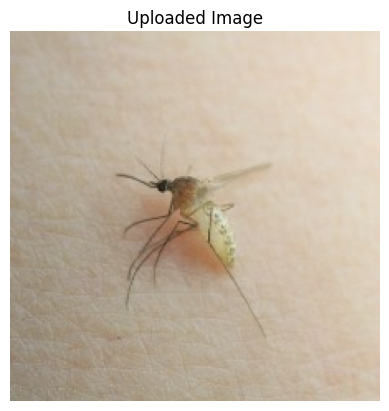

Predicted Class: Culex Quinquefasciatus
Recalibrated Scores:
Aedes Aegypti: 0.9868
Aedes Albopictus: 0.9993
Anopheles Albimanus: 0.9997
Anopheles Arabiensis: 0.9821
Anopheles Atroparvus: 0.9999
Anopheles Coluzzi: 0.9988
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.4970
Anopheles Stephensi: 0.9990
Culex Quinquefasciatus: 0.5372


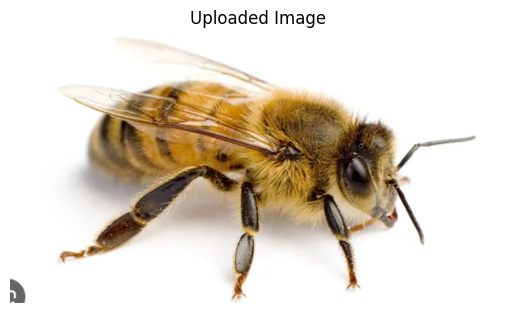

Predicted Class: Unknown
Recalibrated Scores:
Aedes Aegypti: 0.9809
Aedes Albopictus: 0.9921
Anopheles Albimanus: 0.9986
Anopheles Arabiensis: 0.6370
Anopheles Atroparvus: 0.9956
Anopheles Coluzzi: 0.9677
Anopheles Farauti: 0.9997
Anopheles Freeborni: 0.5351
Anopheles Stephensi: 0.9990
Culex Quinquefasciatus: 0.8944


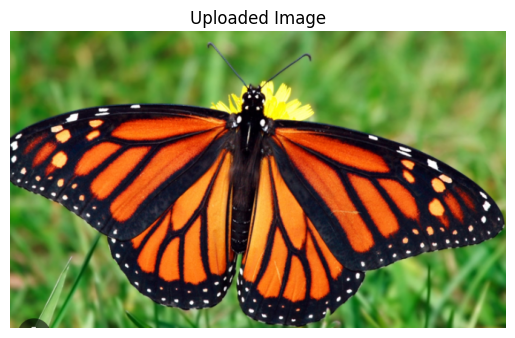

Predicted Class: Unknown
Recalibrated Scores:
Aedes Aegypti: 0.9986
Aedes Albopictus: 0.9967
Anopheles Albimanus: 0.9993
Anopheles Arabiensis: 0.9610
Anopheles Atroparvus: 0.9987
Anopheles Coluzzi: 0.9719
Anopheles Farauti: 0.9999
Anopheles Freeborni: 0.7675
Anopheles Stephensi: 0.9953
Culex Quinquefasciatus: 0.3111


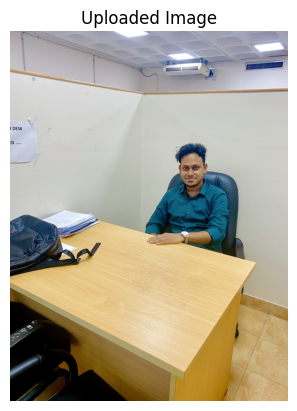

Predicted Class: Unknown


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from timm import create_model
from scipy.special import softmax
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
import io
import cv2

# Load the trained VIT model
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model = create_model('vit_base_patch16_224', num_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']

def openmax_single_image(img):
    # Resize the image to match model's input size
    img = cv2.resize(img, (224, 224))

    # Preprocess the image
    img = img / 255.0  # Normalize image

    # Convert image to PyTorch tensor
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Get model's prediction
    with torch.no_grad():
        prediction = model(img_tensor)

    # Implement OpenMax here...
    # For simplicity, let's assume OpenMax recalibration as inverse of the normalized softmax
    softmax_scores = softmax(prediction[0])
    normalized_scores = softmax_scores / np.sum(softmax_scores)
    recalibrated_scores = 1 - normalized_scores

    # Threshold for unknown class
    unknown_threshold = 0.7  # Adjust as needed

    # If the maximum score is below the unknown threshold, classify as "Unknown"
    if np.max(softmax_scores) < unknown_threshold:
        result = "Unknown"
    else:
        result = class_names[np.argmax(softmax_scores)]

    print("Recalibrated Scores:")
    for i, score in enumerate(recalibrated_scores):
        print(f"{class_names[i]}: {score:.4f}")

    return result, recalibrated_scores

# Create an image uploader
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def on_upload_change(change):
    # When file is uploaded, get the image data and call openmax_single_image
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']

    # Load the uploaded image
    img = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Call openmax_single_image function
    result, recalibrated_scores = openmax_single_image(img_rgb)

    # Display the uploaded image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Uploaded Image')
    plt.show()

    # Display result
    print("Predicted Class:", result)

uploader.observe(on_upload_change, names='_counter')


True openmax implementation

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Correct number of classes based on the model's original training configuration
num_classes = 10  # Correct this based on the original model training

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/datasets/trainset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Extract logits and labels from the training data
logits = []
labels = []
with torch.no_grad():
    for images, label in dataloader:
        images = images.to(device)
        outputs = model(images)
        logits.append(outputs.cpu().numpy().flatten())
        labels.append(label.item())

logits = np.array(logits)
labels = np.array(labels)

# Calculate MAVs and distances for each class
mavs = []
distances = []
for i in range(num_classes):
    class_indices = np.where(labels == i)[0]
    class_logits = logits[class_indices]
    mav = np.mean(class_logits, axis=0)
    mavs.append(mav)
    dist = euclidean_distances([mav], class_logits)
    distances.append(dist.flatten())

# Fit Weibull distribution for each class
weibull_models = []
for dist in distances:
    params = weibull_min.fit(dist, floc=0)
    weibull_models.append(params)

# Save the MAVs and Weibull models
with open('vit_mavs_and_weibull.pkl', 'wb') as f:
    pickle.dump((mavs, weibull_models), f)

print("MAVs and Weibull models are ready for prediction.")


Using device: cuda
MAVs and Weibull models are ready for prediction.


openmax using threshold 0.5

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.5  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.5309090909090909
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.41      0.58       100
      Aedes Albopictus       1.00      0.43      0.60       100
   Anopheles Albimanus       1.00      0.54      0.70       100
  Anopheles Arabiensis       0.96      0.46      0.62       100
  Anopheles Atroparvus       1.00      0.41      0.58       100
     Anopheles Coluzzi       1.00      0.50      0.67       100
     Anopheles Farauti       1.00      0.49      0.66       100
   Anopheles Freeborni       1.00      0.52      0.68       100
   Anopheles Stephensi       1.00      0.57      0.73       100
Culex Quinquefasciatus       1.00      0.51      0.68       100
               Unknown       0.16      1.00      0.28       100

              accuracy                           0.53      1100
             macro avg       0.92      0.53      0.62      1100
          weighted avg       0

openmax using threshold 0.4

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.4  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.64
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.59      0.74       100
      Aedes Albopictus       1.00      0.50      0.67       100
   Anopheles Albimanus       1.00      0.67      0.80       100
  Anopheles Arabiensis       0.96      0.53      0.68       100
  Anopheles Atroparvus       1.00      0.50      0.67       100
     Anopheles Coluzzi       1.00      0.63      0.77       100
     Anopheles Farauti       1.00      0.64      0.78       100
   Anopheles Freeborni       1.00      0.65      0.79       100
   Anopheles Stephensi       1.00      0.64      0.78       100
Culex Quinquefasciatus       1.00      0.69      0.82       100
               Unknown       0.20      1.00      0.34       100

              accuracy                           0.64      1100
             macro avg       0.92      0.64      0.71      1100
          weighted avg       0.92      0.64 

openmax using threshold 0.3

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.3  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.740909090909091
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.68      0.81       100
      Aedes Albopictus       1.00      0.63      0.77       100
   Anopheles Albimanus       1.00      0.74      0.85       100
  Anopheles Arabiensis       0.97      0.61      0.75       100
  Anopheles Atroparvus       1.00      0.62      0.77       100
     Anopheles Coluzzi       0.99      0.80      0.88       100
     Anopheles Farauti       1.00      0.72      0.84       100
   Anopheles Freeborni       1.00      0.82      0.90       100
   Anopheles Stephensi       1.00      0.73      0.84       100
Culex Quinquefasciatus       1.00      0.80      0.89       100
               Unknown       0.26      1.00      0.41       100

              accuracy                           0.74      1100
             macro avg       0.93      0.74      0.79      1100
          weighted avg       0.

openmax using threshold 0.2

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.2  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.8209090909090909
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.75      0.86       100
      Aedes Albopictus       0.99      0.74      0.85       100
   Anopheles Albimanus       1.00      0.79      0.88       100
  Anopheles Arabiensis       0.97      0.68      0.80       100
  Anopheles Atroparvus       1.00      0.80      0.89       100
     Anopheles Coluzzi       0.98      0.88      0.93       100
     Anopheles Farauti       1.00      0.81      0.90       100
   Anopheles Freeborni       1.00      0.86      0.92       100
   Anopheles Stephensi       1.00      0.86      0.92       100
Culex Quinquefasciatus       1.00      0.87      0.93       100
               Unknown       0.34      0.99      0.51       100

              accuracy                           0.82      1100
             macro avg       0.93      0.82      0.85      1100
          weighted avg       0

openmax using threshold 0.1

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.1  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.8927272727272727
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.81      0.90       100
      Aedes Albopictus       0.99      0.90      0.94       100
   Anopheles Albimanus       1.00      0.85      0.92       100
  Anopheles Arabiensis       0.96      0.81      0.88       100
  Anopheles Atroparvus       1.00      0.87      0.93       100
     Anopheles Coluzzi       0.96      0.93      0.94       100
     Anopheles Farauti       1.00      0.88      0.94       100
   Anopheles Freeborni       1.00      0.91      0.95       100
   Anopheles Stephensi       1.00      0.96      0.98       100
Culex Quinquefasciatus       1.00      0.91      0.95       100
               Unknown       0.47      0.99      0.64       100

              accuracy                           0.89      1100
             macro avg       0.94      0.89      0.91      1100
          weighted avg       0

without openmax ROC , AUROC

Using device: cuda


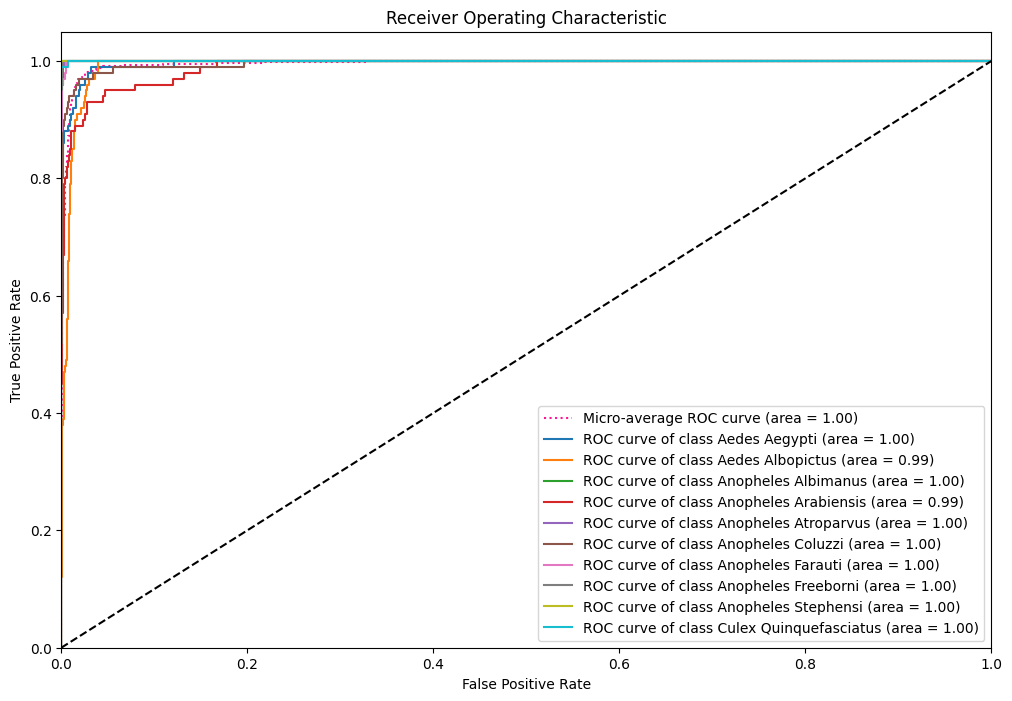

AUROC per class:
Aedes Aegypti: 1.00
Aedes Albopictus: 0.99
Anopheles Albimanus: 1.00
Anopheles Arabiensis: 0.99
Anopheles Atroparvus: 1.00
Anopheles Coluzzi: 1.00
Anopheles Farauti: 1.00
Anopheles Freeborni: 1.00
Anopheles Stephensi: 1.00
Culex Quinquefasciatus: 1.00
Micro-average AUROC: 0.9955742000000001


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare label binarizer
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
n_classes = len(class_names)

# Collect all scores and true labels
true_labels = []
scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        scores.extend(outputs)
        true_labels.extend(labels.numpy())

# Binarize the labels for ROC calculation
true_labels = label_binarize(true_labels, classes=range(n_classes))
scores = np.array(scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC scores
print("AUROC per class:")
for i, name in enumerate(class_names):
    print("{0}: {1:.2f}".format(name, roc_auc[i]))
print("Micro-average AUROC:", roc_auc["micro"])


Using device: cuda


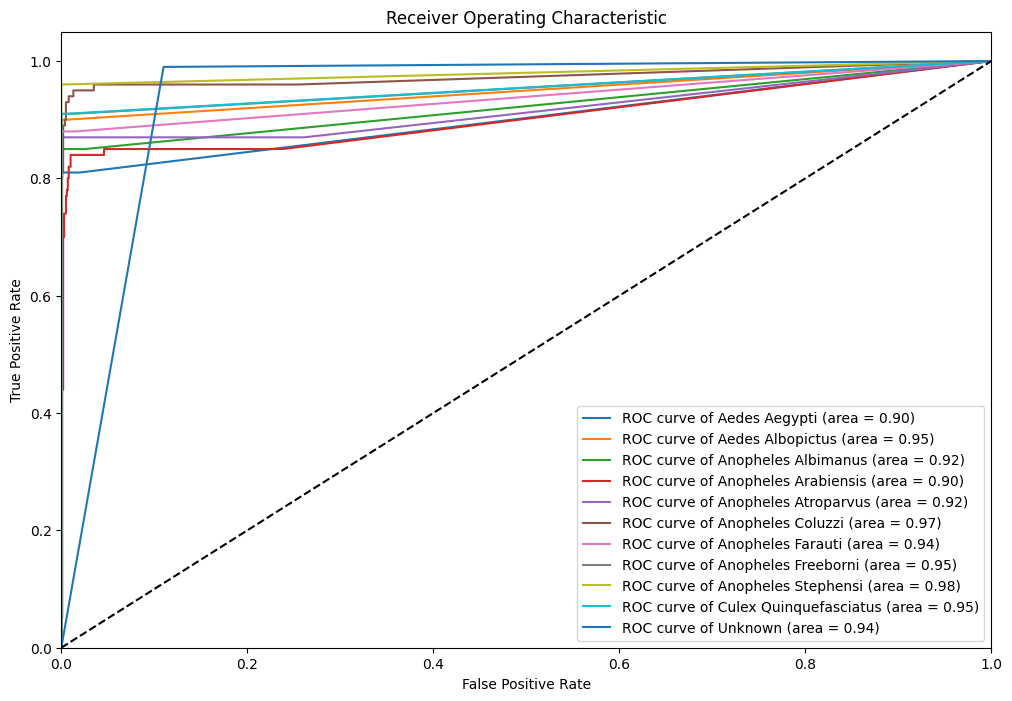

AUROC per class:
Aedes Aegypti: 0.90
Aedes Albopictus: 0.95
Anopheles Albimanus: 0.92
Anopheles Arabiensis: 0.90
Anopheles Atroparvus: 0.92
Anopheles Coluzzi: 0.97
Anopheles Farauti: 0.94
Anopheles Freeborni: 0.95
Anopheles Stephensi: 0.98
Culex Quinquefasciatus: 0.95
Unknown: 0.94


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pickle
import timm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Prepare for ROC
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']
n_classes = len(class_names) - 1  # excluding the 'Unknown' for initial setup

true_labels = []
scores = []

# Adjust logits using OpenMax
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).cpu().numpy()
        adjusted_scores = np.zeros((logits.shape[0], n_classes + 1))  # +1 for unknown

        for i, logit in enumerate(logits):
            recalibrated_scores = np.zeros(n_classes)
            for j in range(n_classes):
                dist = euclidean_distances([logit], [mavs[j]])[0][0]
                shape, loc, scale = weibull_models[j]
                weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
                recalibrated_scores[j] = 1 - weibull_cdf

            if max(recalibrated_scores) < 0.1:  # Threshold for 'Unknown'
                adjusted_scores[i, -1] = 1  # Set last class (Unknown) score to 1
            else:
                adjusted_scores[i, :-1] = recalibrated_scores

            scores.append(adjusted_scores[i])
            true_labels.append(labels.numpy()[i])

scores = np.array(scores)
true_labels = label_binarize(true_labels, classes=range(n_classes + 1))

# Compute ROC and AUROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes + 1):  # Including 'Unknown'
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(12, 8))
for i in range(n_classes + 1):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC
print("AUROC per class:")
for i in range(n_classes + 1):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")


FileUpload(value={}, accept='image/*', description='Upload')

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


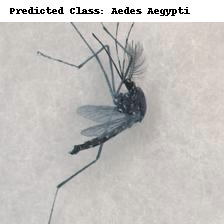

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


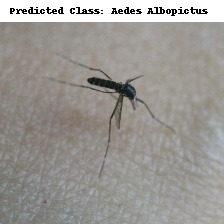

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


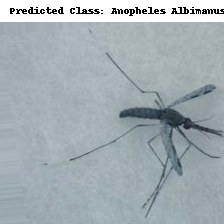

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


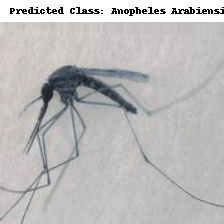

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


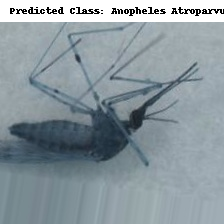

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


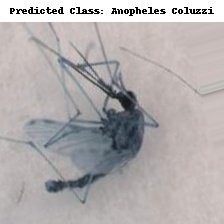

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


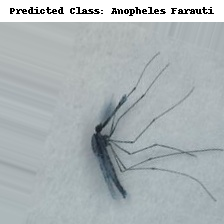

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


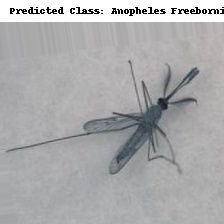

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


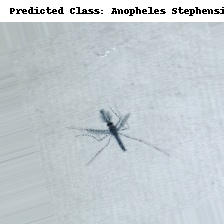

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


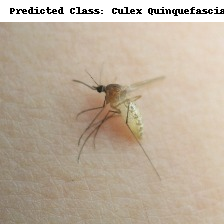

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


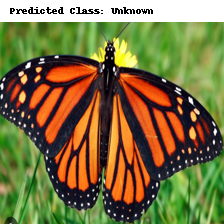

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


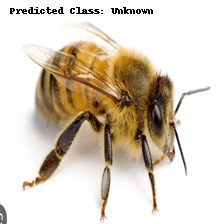

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


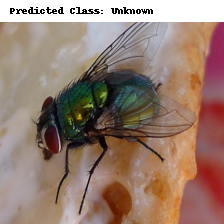

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


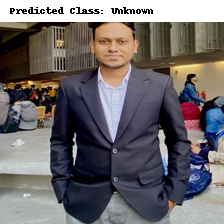

<ipython-input-19-99c71c27da68>:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


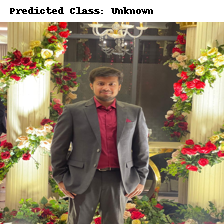

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import timm
from PIL import Image, ImageDraw, ImageFont
import ipywidgets as widgets
from IPython.display import display

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model4(VIT)/vit_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Load MAVs and Weibull models
with open('/content/drive/MyDrive/mosquito_model4(VIT)/vit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
num_classes = len(class_names)

def classify_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor).cpu().numpy().flatten()

    # Calculate distances from MAVs and apply Weibull CDF
    recalibrated_scores = np.zeros(num_classes)
    for i in range(num_classes):
        dist = euclidean_distances([logits], [mavs[i]])[0][0]
        shape, loc, scale = weibull_models[i]
        weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
        recalibrated_scores[i] = 1 - weibull_cdf

    # Apply threshold to determine if the image is unknown or one of the known classes
    threshold = 0.1
    predicted_class_index = np.argmax(recalibrated_scores)
    predicted_class = "Unknown" if recalibrated_scores[predicted_class_index] < threshold else class_names[predicted_class_index]

    # Draw predicted class on the image
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    text = f'Predicted Class: {predicted_class}'
    text_width, text_height = draw.textsize(text, font=font)
    img_width, img_height = img.size
    draw.rectangle([(0, 0), (img_width, text_height + 10)], fill='white')
    draw.text((10, 5), text, fill='black', font=font)

    # Display the image with the predicted class overlaid
    display(img)

# Widget to upload an image
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False  # Allow single file upload
)

def on_upload_change(change):
    if not uploader.value:
        return
    for _, file_info in uploader.value.items():
        content = file_info['content']
        with open("uploaded_image.png", "wb") as f:
            f.write(content)
        classify_image("uploaded_image.png")

uploader.observe(on_upload_change, names='value')
display(uploader)
